# Предсказание IC50 линейными слоями. Предобработка: Моргановские отпечатки

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 20.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
df = pd.read_excel("19_35000.xlsx")
df.head()

,Unnamed: 0,Title,IC50,SMILES
0,NaN,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,NaN,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,NaN,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,NaN,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,NaN,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...


In [ ]:
df = df[["SMILES", "IC50"]]
df.head()

,SMILES,IC50
0,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...,0.000015
1,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...,0.000016
2,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...,0.000033
3,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...,0.000032
4,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...,0.000041


(array([1.835e+03, 9.750e+02, 1.103e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([9.97000000e-06, 2.12249969e-01, 4.24489969e-01, ...,
        3.18317552e+03, 3.18338776e+03, 3.18360000e+03]),
 <BarContainer object of 15000 artists>)

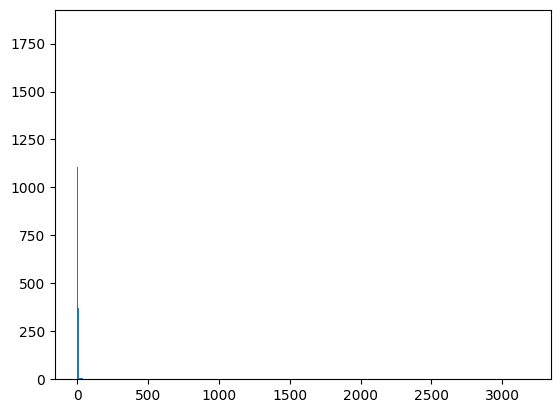

In [ ]:
plt.hist(df['IC50'], bins=15000)

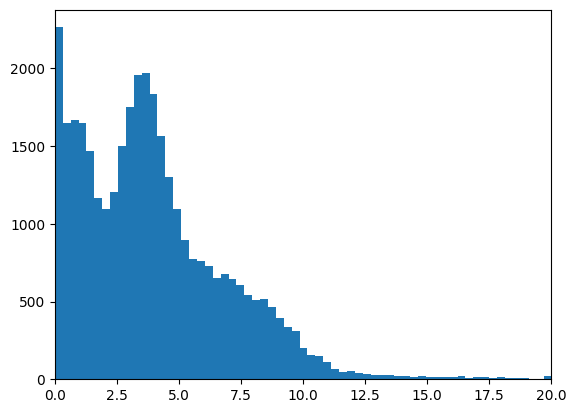

In [ ]:
plt.hist(df['IC50'], bins=10000)
plt.xlim(0, 20)
plt.show()

In [ ]:
df = df[df["IC50"] < 20]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35139 entries, 0 to 35138
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  35139 non-null  object 
 1   IC50    35139 non-null  float64
dtypes: float64(1), object(1)
memory usage: 823.6+ KB


array([[<Axes: title={'center': '0'}>]], dtype=object)

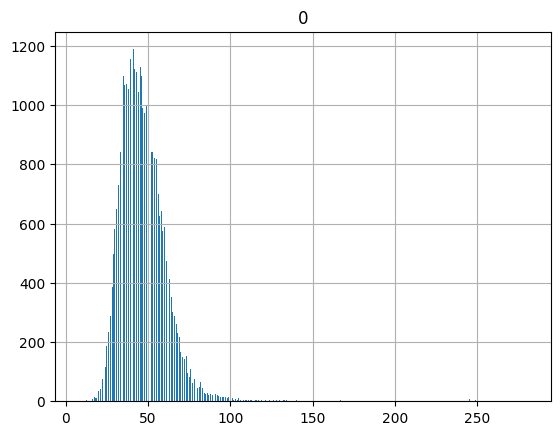

In [ ]:
pd.DataFrame([len(sm) for sm in df["SMILES"]]).hist(bins=500)

In [ ]:
len(df[df["SMILES"].apply(lambda x: len(x) > 150)])

70

In [ ]:
df = df[df["SMILES"].apply(lambda x: len(x) < 150)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35067 entries, 0 to 35138
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  35067 non-null  object 
 1   IC50    35067 non-null  float64
dtypes: float64(1), object(1)
memory usage: 821.9+ KB


In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem

def morgan_fp(mol, radius=3, nBits=1024):
        mol = Chem.MolFromSmiles(mol)
        bit_vec = np.zeros((1,), np.int16)
        DataStructs.ConvertToNumpyArray(
            AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits), bit_vec)
        return bit_vec

radius = 3
nBits = 1024

fp = pd.DataFrame.from_records(df["SMILES"].apply(lambda x: morgan_fp(x, radius, nBits)), columns=[f'bit_id_{i}' for i in range(nBits)])
fp.head()

,bit_id_0,bit_id_1,bit_id_2,bit_id_3,bit_id_4,bit_id_5,bit_id_6,bit_id_7,bit_id_8,bit_id_9,...,bit_id_1014,bit_id_1015,bit_id_1016,bit_id_1017,bit_id_1018,bit_id_1019,bit_id_1020,bit_id_1021,bit_id_1022,bit_id_1023
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
import torch.nn as nn

ReLU = nn.ReLU()

class Net(nn.Module):
    def __init__(self, in_features, out_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_features, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, out_features)

    def forward(self, x):
        x = ReLU(self.fc1(x))
        x = ReLU(self.fc2(x))
        x = ReLU(self.fc3(x))
        x = self.fc4(x)

        return x

In [ ]:
from torch.utils.data import Dataset

class MolDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.values).float()
        self.y = torch.from_numpy(y.values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [ ]:
from torch.utils.data import DataLoader

class Trainer():
    def __init__(self, net, dataset,
                 loss_f,
                 learning_rate=1e-3,
                 epoch_amount = 100,
                 epoch_eval_period = 10,
                 batch_size=16,
                 early_stopping=25,
                 device='cpu',
                 optim=torch.optim.Adam,
                 scheduler=None, permutate=True):

        self.dataset = dataset

        self.start_model = net
        self.best_model = net

        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.epoch_eval_period = epoch_eval_period
        self.batch_size = batch_size
        self.early_stopping = early_stopping

        self.device = device
        self.loss_f = loss_f
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate

        self.train_loss = []
        self.val_loss = []

    def predict(self, X):
        return self.best_model(X)

    def fit(self, X_train, X_test, y_train, y_test):
        Model = self.start_model

        device = torch.device(self.device)

        Model.to(device)

        optimizer = self.optim(params=Model.parameters(), lr=self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train_dataset = self.dataset(X_train, y_train)
        val_dataset = self.dataset(X_test, y_test)

        train = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=self.permutate)
        val = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        best_val = float('inf')
        best_epoch = -1

        for epoch in range(self.epoch_amount):
            mean_loss = 0
            batch_n = 0
            Model.train()

            for batch_X, target in train:
                optimizer.zero_grad()

                batch_X = batch_X.to(device)
                target = target.to(device)

                predicted_values = Model(batch_X).view(-1)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.train_loss.append(mean_loss)

            if epoch % self.epoch_eval_period == 0 or epoch == self.epoch_amount - 1:
              print(f'epoch {epoch}: ')
              print(f'Train_loss: {mean_loss}')

            mean_loss = 0
            batch_n = 0
            Model.eval()

            with torch.no_grad():
                for batch_X, target in val:
                    batch_X = batch_X.to(device)
                    target = target.to(device)

                    predicted_values = Model(batch_X).view(-1)
                    loss = self.loss_f(predicted_values, target)

                    mean_loss += float(loss)
                    batch_n += 1

            mean_loss /= batch_n
            self.val_loss.append(mean_loss)

            if epoch % self.epoch_eval_period == 0 or epoch == self.epoch_amount - 1:
              print(f'Val_loss: {mean_loss}')
              print()

            if (mean_loss < best_val):
                best_val = mean_loss
                best_epoch = epoch
                self.best_model = Model
            elif (epoch - best_epoch > self.early_stopping):
                print(f'{self.early_stopping} эпох без улучшения. Останавливаем обучение.')
                break
            if self.scheduler is not None:
                scheduler.step()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fp, df['IC50'], test_size=0.2, random_state=33)

In [ ]:
in_features = 1024
out_features = 1

net = Net(in_features, out_features)

params = {
    'dataset': MolDataset,
    'net': net,
    'loss_f': nn.MSELoss(),
    'learning_rate': 2e-5,
    'early_stopping': 25,
    'epoch_amount': 500,
    'epoch_eval_period': 5,
    'optim': torch.optim.Adagrad,
    'batch_size': 32,
}

In [ ]:
clf = Trainer(**params)
clf.fit(X_train, X_test, y_train, y_test)

epoch 0: 
Train_loss: 23.216667157894122
Val_loss: 22.866372004422274

epoch 5: 
Train_loss: 15.589891643045702
Val_loss: 15.021889107877557

epoch 10: 
Train_loss: 9.896318367976555
Val_loss: 9.643271256576885

epoch 15: 
Train_loss: 8.12542924478633
Val_loss: 8.086864001642574

epoch 20: 
Train_loss: 7.841131848919215
Val_loss: 7.83487169417468

epoch 25: 
Train_loss: 7.789910180810648
Val_loss: 7.79000162861564

epoch 30: 
Train_loss: 7.771450837906301
Val_loss: 7.772003834897822

epoch 35: 
Train_loss: 7.756835318481636
Val_loss: 7.758835791457783

epoch 40: 
Train_loss: 7.744591872259855
Val_loss: 7.747601817954671

epoch 45: 
Train_loss: 7.733498490930555
Val_loss: 7.737500502846458

epoch 50: 
Train_loss: 7.725263759782676
Val_loss: 7.7282585631717335

epoch 55: 
Train_loss: 7.7139850799142975
Val_loss: 7.719737115773287

epoch 60: 
Train_loss: 7.706470139757937
Val_loss: 7.711786301569505

epoch 65: 
Train_loss: 7.696449079698413
Val_loss: 7.704337142814289

epoch 70: 
Train_lo

In [ ]:
fp_tensor = torch.from_numpy(fp.values).float()

In [ ]:
import random

random_ind = random.randint(0, len(fp))
print(df["IC50"][random_ind])
clf.predict(fp_tensor[random_ind])

5.459


tensor([5.1325], grad_fn=<ViewBackward0>)